In [1]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import random, gc, keras, os

from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from keras.applications.vgg16 import VGG16

%matplotlib inline

Using TensorFlow backend.


# Load Dataset

In [2]:
train_df = pd.read_csv('./data/train.csv')
val_df = pd.read_csv('./data/validation.csv')
test_df = pd.read_csv('./data/test.csv')

print('Train:\t\t', train_df.shape, '\t', len(train_df['label'].unique()))
print('Validation:\t', val_df.shape, '\t', len(val_df['label'].unique()))
print('Test:\t\t', test_df.shape)

Train:		 (194828, 3) 	 128
Validation:	 (6400, 3) 	 128
Test:		 (12800, 2)


In [3]:
train_df.head()

,id,label,url
0,1,5,https://img13.360buyimg.com/imgzone/jfs/t2857/...
1,2,5,http://www.tengdakeli.cn/350/timg01/uploaded/i...
2,3,5,https://img13.360buyimg.com/imgzone/jfs/t8899/...
3,4,5,http://img4.tbcdn.cn/tfscom/i1/2855447419/TB2S...
4,5,5,http://a.vpimg4.com/upload/merchandise/287883/...


In [4]:
# Helper function
train_dir = './data/train'
val_dir = './data/validation'
test_dir = './data/test'

def lr_schedule(epoch):
    """ Learning rate schedule """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

# VGG16

In [5]:
# For reproduciable purpose
seed = 42
K.clear_session()
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(seed)
random.seed(seed)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
tf.set_random_seed(seed)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

# Define parameters
classes = [str(i) for i in range(1, 129)]

# define image generator
train_gen = ImageDataGenerator(rescale=1.0/255)
train_generator = train_gen.flow_from_directory(train_dir, batch_size=160, classes=classes, 
                                                target_size=(224, 224))

val_gen = ImageDataGenerator(rescale=1.0/255)
val_generator = val_gen.flow_from_directory(val_dir, batch_size=286, classes=classes, 
                                            target_size=(224, 224))

Found 191680 images belonging to 128 classes.
Found 6292 images belonging to 128 classes.


### Initial training

In [6]:
# Load pre-trained VGG16
vgg16_base = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Define new CNN models
vgg16 = Sequential()
vgg16.add(vgg16_base)
vgg16.add(Flatten(name='flatten'))
vgg16.add(Dropout(rate=0.5, name='dropout'))
vgg16.add(Dense(128, activation='softmax', name='prediction'))

# Make base model untrainable
vgg16_base.trainable = False

# Model summary
vgg16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dropout (Dropout)            (None, 25088)             0         
_________________________________________________________________
prediction (Dense)           (None, 128)               3211392   
Total params: 17,926,080
Trainable params: 3,211,392
Non-trainable params: 14,714,688
_________________________________________________________________


In [7]:
# Compile the model
opt = keras.optimizers.Adam(lr=lr_schedule(0))
vgg16.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Create call backs
checkpoint = ModelCheckpoint(filepath='./models/vgg16-1-layer-dropout-initial.h5', verbose=0, 
                             monitor='val_acc', save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)
callbacks = [checkpoint, lr_reducer, lr_scheduler]

# fit the mode
history = vgg16.fit_generator(train_generator, steps_per_epoch=100, epochs=100, verbose=2, 
                              callbacks=callbacks, validation_data=val_generator, validation_steps=22)
_ = gc.collect()

Learning rate:  0.001
Epoch 1/100
Learning rate:  0.001
 - 218s - loss: 2.8584 - acc: 0.3584 - val_loss: 2.1217 - val_acc: 0.4900
Epoch 2/100
Learning rate:  0.001
 - 211s - loss: 1.9868 - acc: 0.5182 - val_loss: 1.9088 - val_acc: 0.5478
Epoch 3/100
Learning rate:  0.001
 - 199s - loss: 1.8103 - acc: 0.5591 - val_loss: 1.8571 - val_acc: 0.5779
Epoch 4/100
Learning rate:  0.001
 - 196s - loss: 1.7929 - acc: 0.5764 - val_loss: 1.8830 - val_acc: 0.5722
Epoch 5/100
Learning rate:  0.001
 - 195s - loss: 1.8116 - acc: 0.5826 - val_loss: 1.6966 - val_acc: 0.6006
Epoch 6/100
Learning rate:  0.001
 - 204s - loss: 1.7542 - acc: 0.5985 - val_loss: 1.7262 - val_acc: 0.6074
Epoch 7/100
Learning rate:  0.001
 - 202s - loss: 1.7551 - acc: 0.6053 - val_loss: 1.7062 - val_acc: 0.6147
Epoch 8/100
Learning rate:  0.001
 - 210s - loss: 1.7502 - acc: 0.6113 - val_loss: 1.7101 - val_acc: 0.6244
Epoch 9/100
Learning rate:  0.001
 - 198s - loss: 1.7743 - acc: 0.6096 - val_loss: 1.7321 - val_acc: 0.6305
Epoch 

 - 199s - loss: 0.9144 - acc: 0.8000 - val_loss: 2.1792 - val_acc: 0.6750
Epoch 77/100
Learning rate:  0.001
 - 198s - loss: 0.8969 - acc: 0.8018 - val_loss: 2.1548 - val_acc: 0.6764
Epoch 78/100
Learning rate:  0.001
 - 197s - loss: 0.9889 - acc: 0.7916 - val_loss: 2.2990 - val_acc: 0.6626
Epoch 79/100
Learning rate:  0.001
 - 201s - loss: 0.9696 - acc: 0.7907 - val_loss: 2.1803 - val_acc: 0.6761
Epoch 80/100
Learning rate:  0.001
 - 194s - loss: 1.0416 - acc: 0.7850 - val_loss: 2.2169 - val_acc: 0.6775
Epoch 81/100
Learning rate:  0.001
 - 194s - loss: 1.0290 - acc: 0.7851 - val_loss: 2.1597 - val_acc: 0.6853
Epoch 82/100
Learning rate:  0.0001
 - 198s - loss: 0.8721 - acc: 0.8064 - val_loss: 1.9055 - val_acc: 0.7092
Epoch 83/100
Learning rate:  0.0001
 - 199s - loss: 0.8565 - acc: 0.8126 - val_loss: 1.8939 - val_acc: 0.7082
Epoch 84/100
Learning rate:  0.0001
 - 196s - loss: 0.8099 - acc: 0.8223 - val_loss: 1.9018 - val_acc: 0.7071
Epoch 85/100
Learning rate:  0.0001
 - 199s - loss:

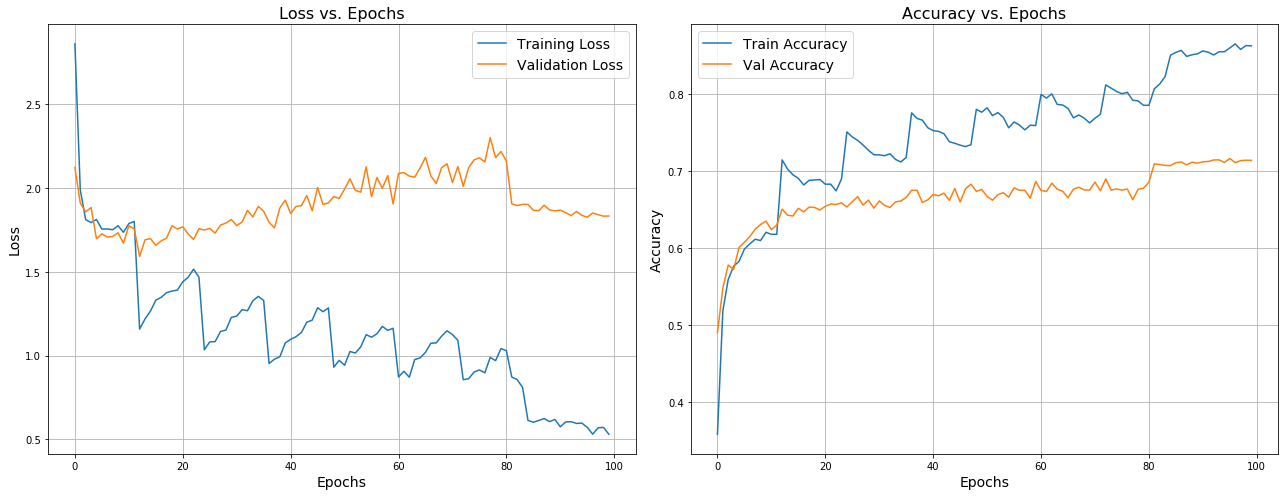

In [8]:
# Visualize the training process
train_loss = history.history['loss']
train_acc = history.history['acc']
val_loss = history.history['val_loss']
val_acc = history.history['val_acc']

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))
ax[0].plot(train_loss, label='Training Loss')
ax[0].plot(val_loss, label='Validation Loss')
ax[0].set_title('Loss vs. Epochs', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Loss', fontsize=14)
ax[0].legend(fontsize=14)
ax[0].grid(True)

ax[1].plot(train_acc, label='Train Accuracy')
ax[1].plot(val_acc, label='Val Accuracy')
ax[1].set_title('Accuracy vs. Epochs', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)
ax[1].legend(fontsize=14)
ax[1].grid(True)
plt.tight_layout()
plt.show()

### Make Predictions

In [9]:
# Load test images
test_ids = []
test_images = []
for idx in test_df['id'].values:
    if os.path.exists('./data/test/' + str(idx) + '.jpg'):
        img = Image.open('./data/test/' + str(idx) + '.jpg')
        if img.mode != 'RGB':
            img = img.convert('RGB')
        img = img.resize((224, 224))
        img = np.asarray(img, dtype=K.floatx())
        test_images.append(img)
        test_ids.append(idx)

# Re-scale the images
test_images = np.array(test_images, dtype=K.floatx())
test_images = test_images / 255.0

In [10]:
# Load the saved model
vgg16 = load_model('./models/vgg16-1-layer-dropout-initial.h5')

# Make predictions
test_pred = vgg16.predict(test_images)
test_label = np.argmax(test_pred, axis=1) + 1

In [11]:
# Sample submission
sample_submission = pd.read_csv('./data/sample_submission.csv', usecols=['id'])
df_submission = pd.DataFrame({'id': test_ids, 'predicted': test_label})

# Merge together
df_submission = pd.merge(sample_submission, df_submission, how='left', on='id')

# Fill missing values
n = df_submission['predicted'].isnull().sum()
guess = np.random.choice(range(1, 129), n, replace=True)
df_submission.loc[df_submission['predicted'].isnull(), 'predicted'] = guess
df_submission['predicted'] = df_submission['predicted'].astype(int)

# Save to disk
df_submission.to_csv('./result/vgg16-1-layer-dropout-initial.csv', columns=['id', 'predicted'], index=False)

_ = gc.collect()

# VGG16 Fune-tuning